In [1]:
import json
import re
import sys
import pandas as pd
import numpy as np

## Preprocessing

In [ ]:
import load_data

In [17]:
train_df = load_data(data_file = '../data/train.data.jsonl', label_file = '../data/train.label.json', perform_stemming = False)
dev_df = load_data(data_file = '../data/dev.data.jsonl', label_file = '../data/dev.label.json', perform_stemming = False)
test_df = load_data(data_file = '../data/test.data.jsonl', label_file = None, perform_stemming = False)

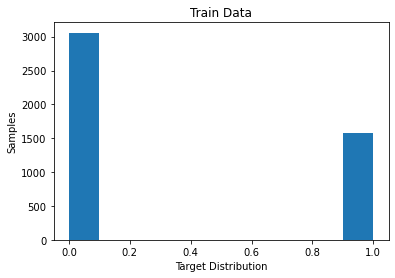

In [19]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.label)
plt.show()

In [20]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,friends_count,contains_profile_background_image,reputation_score_1,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,label
0,552800070199148544,How to respond to the murderous attack on Char...,228,77,True,False,0,True,27923,185,...,414,True,9.985542,0.908971,500,False,False,True,46,0
1,544388259359387648,"You can not condemn an entire race, nation or ...",352,252,False,False,0,False,745,2,...,222,True,0.704036,0.413158,428,False,False,True,115,0
2,552805970536333314,Attempts to extend blame for this to all Musli...,876,400,False,False,0,False,74137,1431,...,1658,True,21.040989,0.954630,6423,False,True,True,149,0
3,525071376084791297,"Rest in Peace, Cpl. Nathan Cirillo. Killed tod...",112,96,False,True,1,True,28103,418,...,1052,True,14.048433,0.933548,2140,True,True,True,157,1
4,498355319979143168,People DEBATING whether MikeBrown shoplifted o...,802,298,False,False,0,False,55920,65,...,914,True,2.114754,0.678947,25389,False,False,True,156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,The soldier shot dead in Wednesday is Ottawa a...,119,36,False,False,0,True,88483,306,...,2454,True,2.663951,0.727071,1903,True,True,True,101,1
5217,552784600502915072,Charlie Hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,2268,True,18.330101,0.948267,0,True,True,True,158,0
5218,499696525808001024,We got through. That is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,521,True,54.639847,0.982027,1163,False,True,True,159,0
5219,580320612155060224,Last position of Germanwings flight 4U9525 at ...,3092,480,False,True,1,True,7991,2384,...,369,True,578.891892,0.998276,1131,True,True,True,146,1


In [22]:
combined_df['text'][5]

'Update - PA: gunman holding hostages in Paris grocery has been killed Wish we would been as decisive with the Lee Rigby killers rot in hell! Update - PA: gunman holding hostages in Paris grocery has been killed” 🙏🙏 GOOD 😃 surely you mean Islamist terrorist not gunman !! good shoot them all Paris will mourn forever Any news on the woman hostage taker? thank fuck for that! GET IN! Fucking lunatic prick Update - PA: gunman holding hostages in Paris grocery has been killed” TangoDown "them all" there was two.... Amen to that 👏👍 well done 🇫🇷best way to deal with the scum Hope he fucking rots in hell. good. great result ,,,,no messing french love em , we would still be fucking around if happened here , PC begrade  rule the uk ...... I hope it was VERY painful . Rot in hell. good! hope he/she rots in hell,sending thoughts to the victims and hostages at this awful time. Evil Bastards!! any news on the hostages or what? Dont care about the terrorists'

## Text-only BERT (Tensorflow)

## Loading BertTokenizer

Load tokenizer based on wordpiece approach

In [16]:
# TODO: Check whether transformerss is allowed
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [17]:
import numpy as np
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.

* Tokenize the text
* Add special tokens - [CLS] and [SEP]
* Pad the sentences to a common length
* Create attention masks for the above PAD tokens

In [18]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True

        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Input are 2 Numpy array. Let me briefly go over them:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

In [19]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
combined_input_ids

array([[  101,  2129,  2000, ...,     0,     0,     0],
       [  101,  2017,  2064, ...,  7499,  1012,   102],
       [  101,  4740,  2000, ...,     0,     0,     0],
       ...,
       [  101,  2057,  2288, ...,  3808,  2034,   102],
       [  101,  2197,  2597, ...,  7471,  3177,   102],
       [  101, 13970, 12269, ...,     0,     0,     0]])

In [21]:
len(combined_input_ids)

5221

## Creating Custom Model

Base TFBert Model with Dense layer and sigmoid activation as head.

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(512,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

## TFBertModel

The bare Bert Model transformer outputing raw hidden-states without any specific head on top. https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [24]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Implementing custom model

In [25]:
model = create_model(bert_model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 1024),  335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]   

## Training

Fit for 5 epochs:

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [35]:
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0.1,callbacks=[callback], epochs=2,batch_size=2)

Epoch 1/2
2349/2349 [==============================] - 3801s 2s/step - loss: 0.0551 - accuracy: 0.9838 - precision: 0.9757 - recall: 0.9769 - val_loss: 0.3225 - val_accuracy: 0.8967 - val_precision: 0.8284 - val_recall: 0.8485
Epoch 2/2
2349/2349 [==============================] - 3797s 2s/step - loss: 0.0362 - accuracy: 0.9885 - precision: 0.9832 - recall: 0.9832 - val_loss: 0.5083 - val_accuracy: 0.8757 - val_precision: 0.7747 - val_recall: 0.8545


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

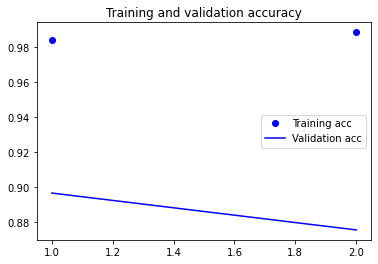

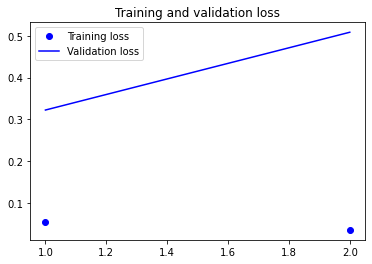

In [37]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [39]:
model.save("./pure_bert/pure_bert_v11")

INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


INFO:tensorflow:Assets written to: ./pure_bert/pure_bert_v11/assets


## Testing

In [40]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)
predicted_labels = [convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [41]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output.json', 'w') as f:
    json.dump(submission, f)

,id,target
0,544382249178001408,rumour
1,525027317551079424,rumour
2,544273220128739329,rumour
3,499571799764770816,non-rumour
4,552844104418091008,non-rumour
...,...,...
576,553581227165642752,non-rumour
577,552816302780579840,non-rumour
578,580350000074457088,rumour
579,498584409055174656,non-rumour
